In [40]:
gen = "QGSM"

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
true = True
false = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_NAME = f'{gen}_Big_InvTime'
if gen == 'QGSM' or gen == 'EPOS':
    INPUT_FILE = f'data/modeled/PD173_{gen}_Big_InvTime'
else:
    raise Exception('Wrong generator format!')

doSaveFigures = True
doSaveModel = False

isTimeOfFlight = True
isSimpleTime = False
isBigRings = True


number_of_epoches_lin = 50        # Количество эпох в обучении полносвязной нейросети
number_of_epoches_conv = 50      # Количество эпох в обучении сверточной нейросети
batch_size_N = 800                    # Размер батча
training_set_part = 0.8             # Часть от 0 до 1 выделяемая на тренировочный набор
to_predict = [0]
loss_weights = [1, 1, 1]
threshold = 5

name_of_label = ['Imp. parameter [fm]','coordinate [m]', 'time of first particle']

n_out = len(to_predict)
dot_size = 0.3


# Normalize event features
if isTimeOfFlight:
    if isSimpleTime:
        if isBigRings:
            FEATURES_AMPLITUDES = [20, 352, 2]
        else:
            FEATURES_AMPLITUDES = [20, 32, 6]
    else:
        if isBigRings:
            FEATURES_AMPLITUDES = [50, 100, 2]
        else:
            FEATURES_AMPLITUDES = [200, 32, 6]
else:
    if isBigRings:
        FEATURES_AMPLITUDES = [0.015, 100]
    else:
        FEATURES_AMPLITUDES = [0.015, 50]

avg_pion_times = [3.345, 5.675, 8.355]
input_data = []
times_of_first_particles = []

imp_parameters = []

with open(f'{INPUT_FILE}.dat', 'r') as inpf:
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    if isTimeOfFlight:
        maximum_hits = int(s[2])                                                                                                      #
        n_lines = int(s[4])                                                                                                           #

    if isTimeOfFlight:
        number_of_features = n_lines * maximum_hits
    else:
        number_of_features = 2

    # number_of_features = 1 #len(s[8:])
    print("Number of features: {}".format(number_of_features))
    print(l)
    max_b = 0.0
    max_coord = 0.0
    max_phi = 0.0
    norm_labels = True

    # l = inpf.readline()

    amount = 0
    for line in inpf:
        features = []
        s = line.strip().split()
        b = float(s[0])
        coord = float(s[1])
        phi_b = float(s[2])

        if norm_labels:
            max_b = max(b, max_b)
            max_phi = max(abs(phi_b), max_phi)
            max_coord = max(abs(coord), max_coord)

        imp_parameters.append(b)

        n = 0
        # investigated_det = 1
        timeFeatures = []
        cellFeatures = []
        detFeatures = []
        if isTimeOfFlight:
            for particlePlace in range(maximum_hits):
                timeFeatures.append(float(s[3 + particlePlace + 0 * maximum_hits]) / FEATURES_AMPLITUDES[0])
                cellFeatures.append(float(s[3 + particlePlace + 1 * maximum_hits]) / FEATURES_AMPLITUDES[1])
                detFeatures.append(float(s[3 + particlePlace + 2 * maximum_hits]) / FEATURES_AMPLITUDES[2])
            features = timeFeatures + cellFeatures + detFeatures
        else:
            features.append(float(s[3]) / FEATURES_AMPLITUDES[0])                                                                            # Reading n features in given angles
            features.append(float(s[4]) / FEATURES_AMPLITUDES[1])


        if s[3] != 'nan' and s[3]!= '0':
            times_of_first_particles.append(float(s[3]))
            input_data.append([b, coord, phi_b, features])
            amount += 1
        # input_data.append([b, coord, features])



maximum_values = [max_b, max_coord, max_phi]
print(input_data[0:5])
print(len(input_data))

cuda:0
Number of features: 450
Maximum hits: 150 Lines: 3 

[[0.158, 0.0, 0.0, [-0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, -0.66666664, 1.0, 1.0, 0.28571428, 0.28571428, 0.28571428, 0.28571428, 0.28571428, 0.28571428, 0.16666666, 0.16666666, 0.16666666, 0.16666666, 0.09090909, 0.09090909, 0.07407407199999999, 0.0625, 0.0625, 0.0625, 0.0625, 0.054054055999999996, 0.047619048, 0.047619048, 0.038461538, 0.0186915886, 0.012345678799999999, 0.00921659, 0.0049140048, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [41]:
# Создание класса для набора данных с двумя функциями
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):           # В этом методе создаются две переменные для характеристик и для меток
        self.labels = labels
        self.features = features

    def __len__(self):                       # Эта функция должна возвращать размер набора данных
        return self.labels.shape[0]

    def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
        if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка
            idx = idx.tolist()

        label = self.labels[idx]

        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

        return sample

def norm_label(value: float, label_idx: int) -> float:
    if label_idx == 0:
        res = (value * 2 / maximum_values[0]) - 1.0
        return res
    else:
        res = value / maximum_values[label_idx]
        return res

def get_correct_predictions_binary(preds: torch.Tensor, values: torch.Tensor, threshold: float) -> torch.Tensor:
    confusion_matrix = torch.zeros((2,2))
    normed_threshold = norm_label(threshold, 0)
    for i in range(preds.shape[0]):
        pred_is_big = preds[i][0].item() >= normed_threshold
        value_is_big = values[i].item() >= normed_threshold
        confusion_matrix[int(value_is_big)][int(pred_is_big)] += 1

    return confusion_matrix

def denorm_label(value: float, label_idx: int) -> float:
    if label_idx == 0:
        res = (value + 1.0) * maximum_values[0] / 2
        return res
    else:
        res = value * maximum_values[label_idx]
        return res

np.random.shuffle(input_data)

features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), n_out))
coordinates = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    if norm_labels:
        normed_labels = []
        for i in to_predict:
            normed_labels.append( norm_label(elem[i], i) )
        labels[incr] = np.array(normed_labels)
    else:
        labels[incr] = np.array([elem[0], elem[1], elem[2]])

    features[incr] = np.array(elem[3])
    coordinates[incr] = np.array(elem[1])

    incr += 1


# Divide into test and training sets
size_of_training_set = int(features.shape[0] * training_set_part)
size_of_test_set = features.shape[0] - size_of_training_set

# Divide labes into test and training sets
train_labels = torch.tensor(labels[:size_of_training_set]).to(device)
test_labels = torch.tensor(labels[size_of_training_set:]).to(device)

train_coordinates = torch.flatten(torch.tensor(coordinates[:size_of_training_set])).to(device)
test_coordinates = torch.flatten(torch.tensor(coordinates[size_of_training_set:])).to(device)

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32).to(device)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32).to(device)

print('Train features shape: {}'.format(train_features.shape))
print('Test features shape: {}'.format(test_features.shape))

print('Train labels shape: {}'.format(train_labels.shape))
print('Test labels shape: {}'.format(test_labels.shape))


Train features shape: torch.Size([3103, 450])
Test features shape: torch.Size([776, 450])
Train labels shape: torch.Size([3103, 1])
Test labels shape: torch.Size([776, 1])


In [42]:
def loss_with_weights(func_predicted, func_labels, boost_low):
    res = 0
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx

        func_preds = func_predicted[:,idx_mod]
        func_lbls = func_labels[:,idx_mod]

        if boost_low:
            current_loss = F.mse_loss(func_preds, func_lbls, reduction='none')

            for i in range(current_loss.shape[0]):
                current_loss[i] /= denorm_label(func_lbls[i], 0)
            current_mean = current_loss.mean()
        else:
            current_mean = F.mse_loss(func_preds, func_lbls)


        res += (current_mean * loss_weights[idx])
    return res

# Объявление класса сверточной сети
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(n_lines, 6), stride=(1, 2))
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(n_lines, 40), stride=(1, 40))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        

        self.conv_outp_features = int((maximum_hits)/2 - 2)

        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int(self.conv_outp_features )), out_features=128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=self.lin1.out_features, out_features=64)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        self.lin3 = nn.Linear(in_features=self.lin2.out_features, out_features=32)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)


        self.out = nn.Linear(in_features=self.lin3.out_features, out_features=n_out)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = torch.reshape(t, (-1, 1, n_lines, maximum_hits))
        
        t = F.leaky_relu(self.conv1(t))
        
        # t = F.relu(self.conv2(t))
        # t = torch.reshape(t, (-1, self.conv1.out_channels, self.conv_outp_features))
        # t = self.maxpool1d(t)
        
        t = torch.reshape(t, (-1, int(self.conv1.out_channels * self.conv_outp_features )))
        t = F.leaky_relu(self.lin1(t))
        t = F.leaky_relu(self.lin2(t))
        t = F.leaky_relu(self.lin3(t))
        
        t = self.out(t)
        return t

class NetworkDense(nn.Module):
    def __init__(self):
        super(NetworkDense, self).__init__()
        if isTimeOfFlight:
            self.lin1 = nn.Linear(in_features = number_of_features, out_features = 256)             # Time
        else:
            self.lin1 = nn.Linear(in_features = number_of_features, out_features = 4)               # Stat
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        if isTimeOfFlight:
            self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 64)          # Time
        else:
            self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 8)           # Stat
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = self.lin2.out_features, out_features = 16)              # Same
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02) # было 3
    
        self.lin4 = nn.Linear(in_features = self.lin3.out_features, out_features = 4)               # Same
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = self.lin4.out_features, out_features = 8)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = self.lin5.out_features, out_features = 4)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = self.lin4.out_features, out_features = n_out)
        # self.out = nn.Linear(in_features = number_of_features, out_features = n_out)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.leaky_relu(self.lin1(t))
        t = F.leaky_relu(self.lin2(t))
        t = F.leaky_relu(self.lin3(t))
        t = F.leaky_relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = self.out(t)
        return t

In [43]:
# Сверточная сеть - только для времяпролетных характеристик
# net = NetworkConv().to(device)
# Полносвязная сеть
net = NetworkDense().to(device)


# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_labels, train_features)
divisors = [400, 800, 1200, 1600, 2220, 3700, 5550, 8880, 14800, 29600]                              # для 177600
print(net)
optimizer_c = optim.Adam(net.parameters(), lr=0.001)


total_loss_c = []
total_val_loss_c = []

# Learning process
for epoch in range(number_of_epoches_conv):
    t_loss = 0
    idx = int(epoch * 10 / number_of_epoches_conv)
    batch_size = divisors[idx]

    trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)

    for batch in trDL:
        batch_labels = (batch['label']).reshape((-1,1)).type(torch.FloatTensor).to(device)
        batch_features = batch['feature'].type(torch.FloatTensor).to(device)

        predicted = net(batch_features)


        loss = loss_with_weights(predicted, batch_labels, boost_low=false)
        # loss = lossWithKL(predicted, batch_labels, boost_low=false, betaKL=beta)

        optimizer_c.zero_grad()
        loss.backward()
        optimizer_c.step()

        t_loss += (loss.item() * batch_size/len(trDS))


    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)

        test_preds = net(test_features)
        test_loss = loss_with_weights(test_preds, test_labels, boost_low=false)
        # test_loss = lossWithKL(test_preds, test_labels, boost_low=false, betaKL=beta)
        total_val_loss_c.append(test_loss.item())

        print("Epoch: {:4d} |---> train loss is {:4.10f}, validation loss is {:4.10f}, {}"
            .format(epoch, t_loss, test_loss, batch_size))

NetworkDense(
  (lin1): Linear(in_features=450, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)
Epoch:    0 |---> train loss is 0.5548116971, validation loss is 0.5486138049, 400
Epoch:    1 |---> train loss is 0.5416833851, validation loss is 0.5343524520, 400
Epoch:    2 |---> train loss is 0.5181202341, validation loss is 0.4908979932, 400
Epoch:    3 |---> train loss is 0.4346851414, validation loss is 0.3709299388, 400
Epoch:    4 |---> train loss is 0.3689829434, validation loss is 0.3580317864, 400
Epoch:    5 |---> train loss is 0.3482632125, validation loss is 0.3549374905, 800
Epoch:    6 |---> train loss is 0.3484160063, validation loss is 0.3505359522, 800
Epoch:    7 |---> train loss is 0.3395974771, validation loss is 0.3366662566, 800
Epoch:    8 |---

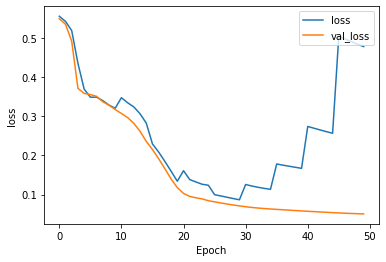

Test mse is 0.05
MSE for Imp. parameter [fm] is 0.050
//////////////////
MSE for Imp. parameter [fm] is 3.040, sqrt(MSE) = 1.744
MAE for Imp. parameter [fm] is 1.29366
tensor([[ 79.,  12.],
        [ 14., 671.]])


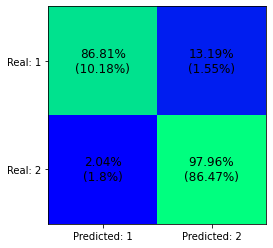

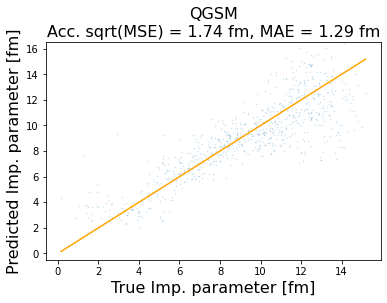

In [44]:
# График обучения и запись информации в файл
with torch.no_grad():
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')

    if doSaveFigures:
        plt.savefig(f'{IMAGE_NAME}_LearningPlot', dpi=300)
    plt.show()

    test_predictions_c = net(test_features)
    test_mse_c = F.mse_loss(test_predictions_c, test_labels)

    zero_features = torch.zeros((1,number_of_features)).to(device)
    zero_preds = net(zero_features)
    zero_preds_denorm = np.zeros(n_out)
    # print(zero_preds)
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        zero_preds_denorm[idx_mod] = denorm_label(zero_preds[:,idx_mod].item(), idx)
    # print(zero_preds_denorm)
    # print(maximum_values)
    print("Test mse is {:2.2f}" .format(test_mse_c))

    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        preds = test_predictions_c[:,idx_mod]
        lbls = test_labels[:,idx_mod]
        print('MSE for {} is {:2.3f}'.format(name_of_label[idx], (F.mse_loss(preds, lbls))))
    print('//////////////////')
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        preds = denorm_label(test_predictions_c[:,idx_mod], idx)
        lbls = denorm_label(test_labels[:,idx_mod], idx)

        # print(preds[:10])
        # print(lbls[:10])
        meanAbsErr =  torch.mean(abs(preds - lbls)).item()
        sigma_sq = F.mse_loss(preds, lbls).item()
        print('MSE for {} is {:2.3f}, sqrt(MSE) = {:2.3f}'.format(name_of_label[idx], sigma_sq, np.sqrt(sigma_sq)))
        print('MAE for {} is {:2.5f}'.format(name_of_label[idx], meanAbsErr))


    conf_m = get_correct_predictions_binary(test_predictions_c, test_labels[:,0], threshold)
    print(conf_m)
    conf_m_normed = torch.clone(conf_m)

    for i in range(conf_m.shape[0]):
        norm = conf_m[i][0].item() + conf_m[i][1].item()
        conf_m_normed[i] /= norm


    fig, ax = plt.subplots()
    im = ax.imshow(conf_m_normed, cmap='winter')

    ax.set_xticks(np.arange(conf_m.shape[0]))
    ax.set_yticks(np.arange(conf_m.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(conf_m.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(conf_m.shape[0]):
        for j in range(conf_m.shape[1]):
            cell_label = str(round(conf_m_normed[i][j].item()*100, 2)) + '%\n(' + str(round(conf_m[i][j].item()*100/test_features.shape[0], 2)) + '%)'
            # text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0],2)) + '%', ha="center", va="center", size=12)
            text = ax.text(j, i, cell_label, ha="center", va="center", size=12)

    plt.show()


    # Plot scatter of results
    dot_size = 0.3
    for idx in to_predict:
        idx_mod = 0 if n_out == 1 else idx
        tlbl = denorm_label( np.array(test_labels[:,idx_mod].to('cpu')) , idx )                                              # Настоящие прицельные параметры
        tpr_c = denorm_label( np.array(test_predictions_c[:,idx_mod].to('cpu')), idx)                                          # Предсказанные


        element_wise_diff_c = (tpr_c - tlbl)

        tdiff_c = np.array(element_wise_diff_c)                                       # Разница со знаком
        tabsdiff_c = abs(np.array(element_wise_diff_c))                               # Разница без знака
        tmse_c = np.array((tpr_c - tlbl)**2)                                         # MSE



        # Зависимость Предсказанного параметра от Истинного
        max_val = max(tlbl)
        min_val = min(tlbl)
        plt.scatter(tlbl, tpr_c, s=dot_size, alpha=0.2)
        plt.plot([min_val, max_val], [min_val, max_val], color='orange')
        plt.xlabel('True Imp. parameter [fm]', fontsize=16)
        plt.ylabel('Predicted Imp. parameter [fm]', fontsize=16)
        plt.title(f'{gen}\nAcc. sqrt(MSE) = {np.sqrt(sigma_sq):.2f} fm, MAE = {meanAbsErr:.2f} fm', fontsize=16)
        plt.ylim([-0.5,16.5])
        if doSaveFigures:
            plt.savefig((f'{IMAGE_NAME}_RegressionResult').replace(".", "_"), dpi=300, bbox_inches='tight')
        plt.show()


    with open(f'Regression{gen}.txt', 'a') as results:
        results.write(f'\n{IMAGE_NAME}             {np.sqrt(sigma_sq):.3f}       {meanAbsErr:.3f}')


